In [15]:
!pip install umap-learn
!pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 12.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: h5py
    Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotpy 1.2.0 requires h5py==2.8.0, but you have h5py 3.8.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Capstone Project 

- Preamble: Spotify released an API that reports the audio features of its songs, such as “tempo” or “energy”. Here, we will use these features of 50k randomly picked songs to predict the genre that the song belongs to.

- Scope: This is a “for real” project, that includes parts of all aspects of the class. It is designed to stretch your abilities. No one is expecting perfection – the question is what you can come up with in a couple of weeks, while you have other ongoing commitments, which simulates typical industry conditions. If achieving reasonable performance, you will be able to use this capstone project as a “portfolio” item that you can highlight in interviews for internships and jobs. Note that this is not a toy dataset or project. As real data always has (many) real issues, any success in classification will be hard earned and not easily forthcoming.

The columns represent, in order (from left to right): 

Column 1: unique Spotify ID of each song

Column 2: artist name

Column 3: song name

Column 4: popularity of the music (what percentage of users know about it, from 0 to 99%) 

Column 5: acousticness (an audio feature) on a scale from 0 to 1

Column 6: danceability (an audio feature) on a scale from 0 to 1

Column 7: the duration of the music (in milliseconds)

Column 8: energy (an auditory feature) on a scale from 0 to 1

Column 9: instrumentality (an audio feature) on a scale from 0 to 1

Column 10: key of the song (in musical notation)

Column 11: liveness (an audio feature) on a scale from 0 to 1

Column 12: loudness (in dB relative to some threshold)

Column 13: mode of the song (musical)

Column 14: speechiness (an audio feature), on a scale from 0 to 1

Column 15: tempo (in beats)

Column 16: obtained date (when was this information obtained from Spotify)

Column 17: valence (an audio feature), on a scale from 0 to 1

Column 18: Genre of the song (there are 10 different genres, e.g. “Rock” or “Country”)

## Todo: 
* Write code that creates a classification model (of your choice, can be anything we covered in class – including SVM, trees, forests, boosting methods, neural networks, etc.; for good classification performance, make sure to include a suitable dimensionality reduction and clustering step before attempting the classification) that predicts the genre of a song in the test set from the rest of the data.
* Make sure to do the following train/test split: For *each* genre, use 500 randomly picked songs for the test set and the other 4500 songs from that genre for the training set. So the complete test set will be 5000x1 randomly picked genres (one per song, 500 from each genre). Use all the other data in the training set and make sure there is no leakage.

* Use this test set to determine the AUC of your model. Try to get the AUC as high as possible without having any leakage between training and test set.

* Write a brief report (1-2 pages) as to how you built your model, how you made your design choices (why you did what you did) and addressing how you handled the challenges below. Make sure to state your final AUC at the bottom of the report and please include a plot of the ROC curve in your report. As dimensionality reduction will be critical, please also include a visualization of the genres as clusters in the lower dimensional space (lower than the dimensionality of the original data) you uncovered and include a comment as to what you think about this space/clustering. Also make sure to comment on what you think is the most important factor that underlies your classification success.

* For extra credit, include some interesting non-trivial observation or data visualization in your report.

In [149]:
import pandas as pd 
import numpy as np 
import random

# setting the seed
np.random.seed(18636966)

data = pd.read_csv('musicData.csv')

In [108]:
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [109]:
for feature in data.columns:
    print(feature, len(data[feature].unique()))

instance_id 50001
artist_name 6864
track_name 41700
popularity 100
acousticness 4194
danceability 1089
duration_ms 26029
energy 2086
instrumentalness 5132
key 13
liveness 1647
loudness 17248
mode 3
speechiness 1338
tempo 29395
obtained_date 6
valence 1616
music_genre 11


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [184]:
data.describe()


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,49999.000000,49999.000000,49999.000000,4.999900e+04,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000
mean,44.220844,0.306383,0.558238,2.212488e+05,0.599759,0.181587,0.193898,-9.133669,0.093588,0.456262
std,15.541874,0.341343,0.178633,1.286705e+05,0.264560,0.325397,0.161638,6.163017,0.101374,0.247120
min,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.859500,0.036100,0.257000
50%,45.000000,0.144000,0.568000,2.192800e+05,0.643000,0.000158,0.126000,-7.276000,0.048900,0.448000
75%,56.000000,0.552000,0.687000,2.686060e+05,0.815000,0.155000,0.244000,-5.173000,0.098550,0.648000
max,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


## Exploratory Data Analysis(EDA)


In [181]:
# light data cleaning

# Drop unnecessary columns
data = data.drop(columns=['instance_id', 'artist_name', 'track_name', 'obtained_date'])

# Remove rows with missing values
data = data.dropna()

# Remove duplicate rows
data = data.drop_duplicates()

# Assuming `df` is your dataframe and 'mode' and 'keys' are your columns
data_encoded_km = pd.get_dummies(data, columns=['mode', 'key'])


### Distribution of Music_genre vs Key

In [129]:
data_encoded_km.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'music_genre', 'mode_Major', 'mode_Minor', 'key_A', 'key_A#',
       'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F',
       'key_F#', 'key_G', 'key_G#'],
      dtype='object')

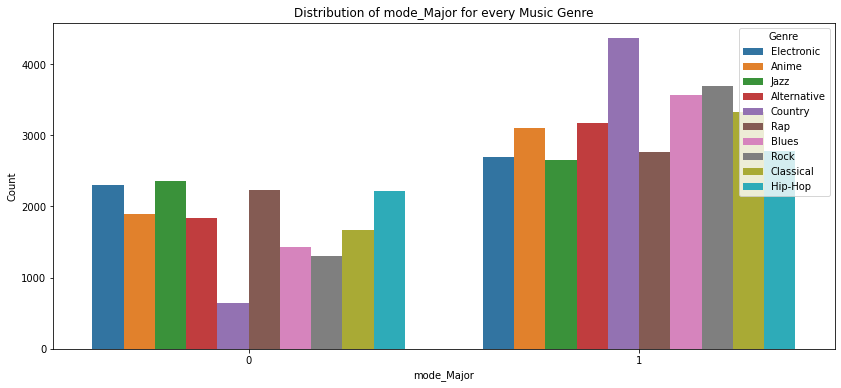

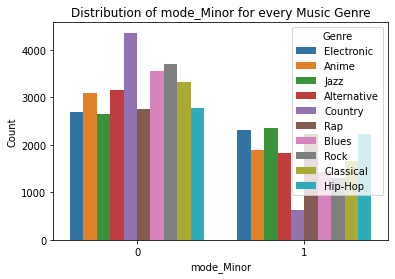

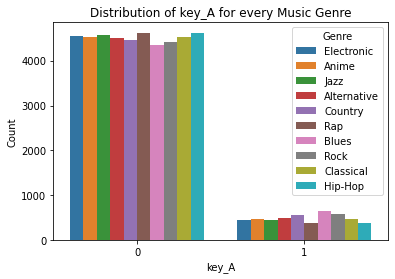

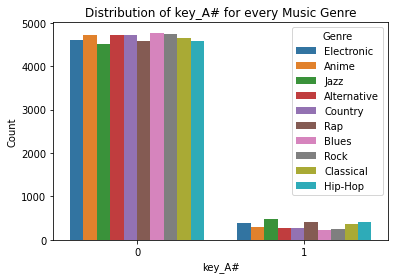

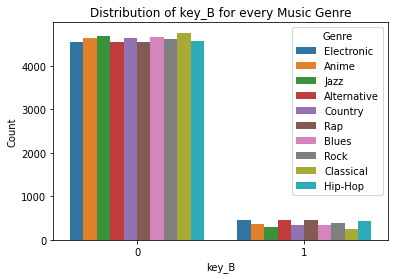

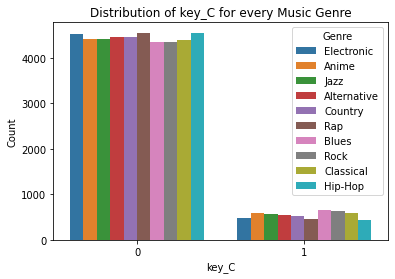

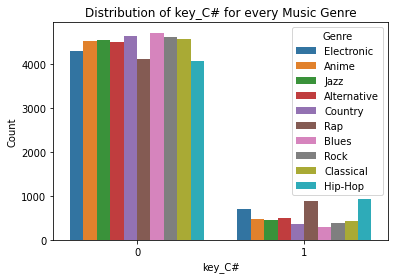

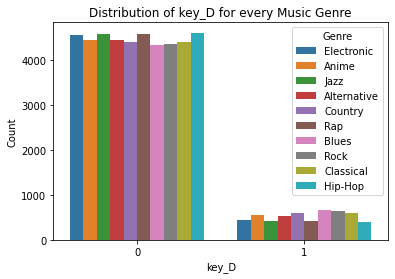

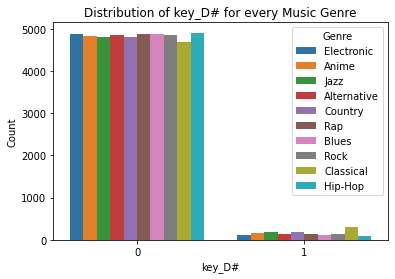

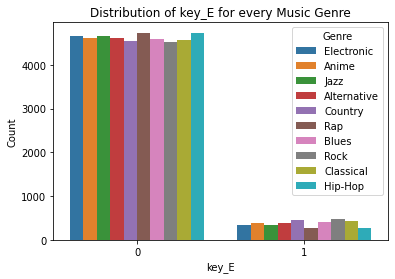

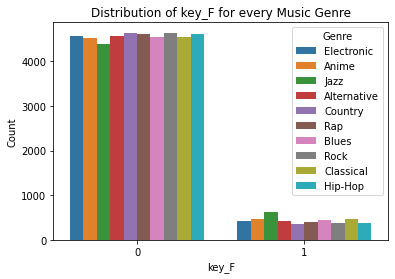

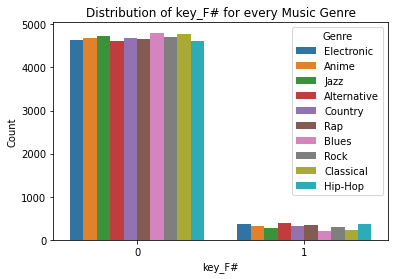

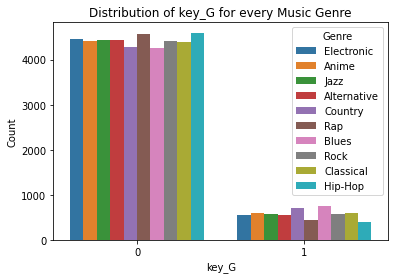

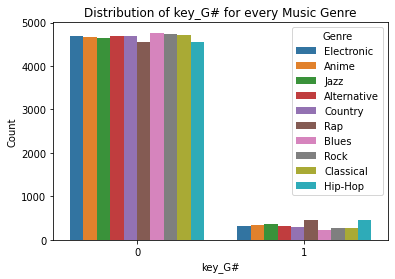

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df' and it has columns 'genre' and 'key'
plt.figure(figsize=(14,6))
for col in data_encoded_km.columns[12:]:
    sns.countplot(x=col, hue='music_genre', data=data_encoded_km)

    plt.title('Distribution of '+col+' for every Music Genre')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Genre', loc='upper right')

    plt.show()


### Distribution of Predictor

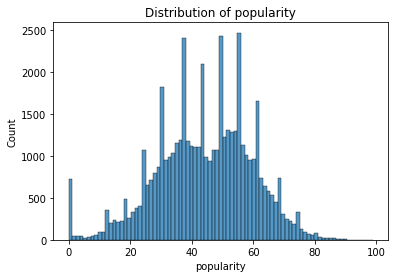

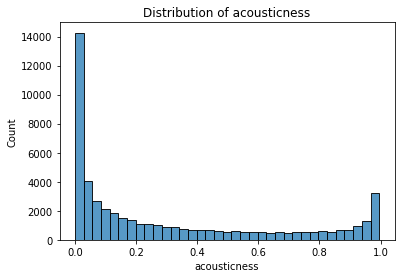

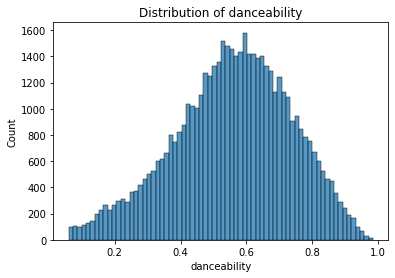

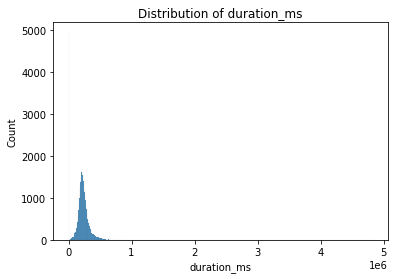

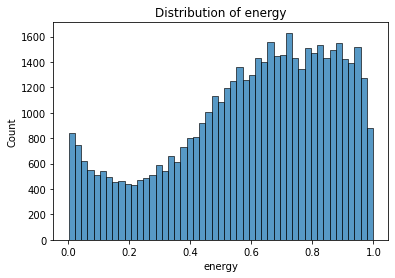

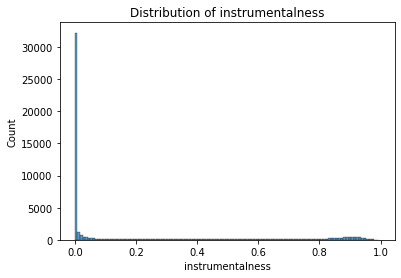

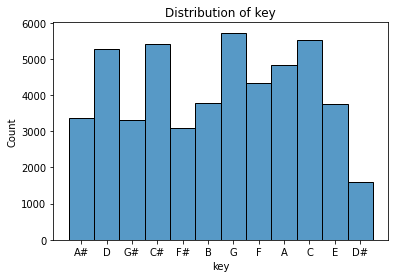

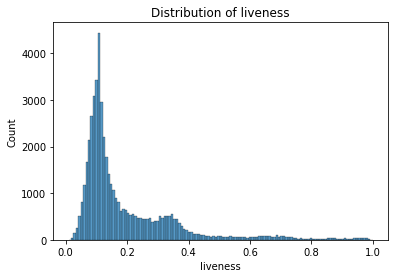

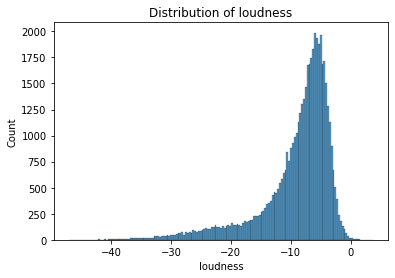

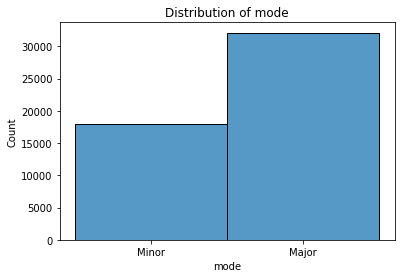

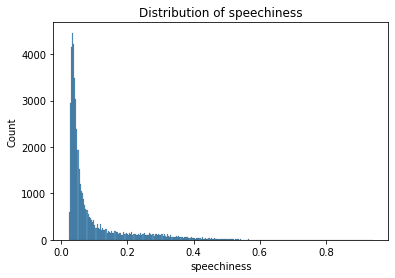

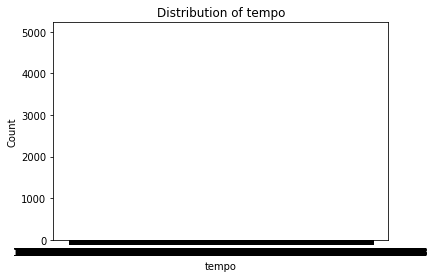

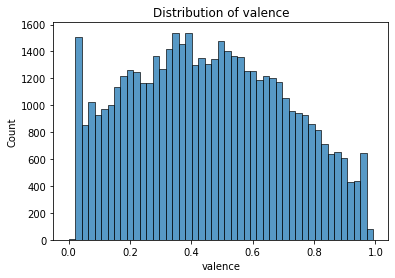

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of each feature
features = data.columns[:-1]
for feature in features:
    plt.figure()
    sns.histplot(data[feature])
    plt.title(f'Distribution of {feature}')


#### Why removing the keys and mode altogether from predictors

By inspecting the correlatoin matrix we can see that there are meaningless correlation between the keys and th mode with the other predictos. 


Text(0.5, 1.0, 'Correlation Matrix')

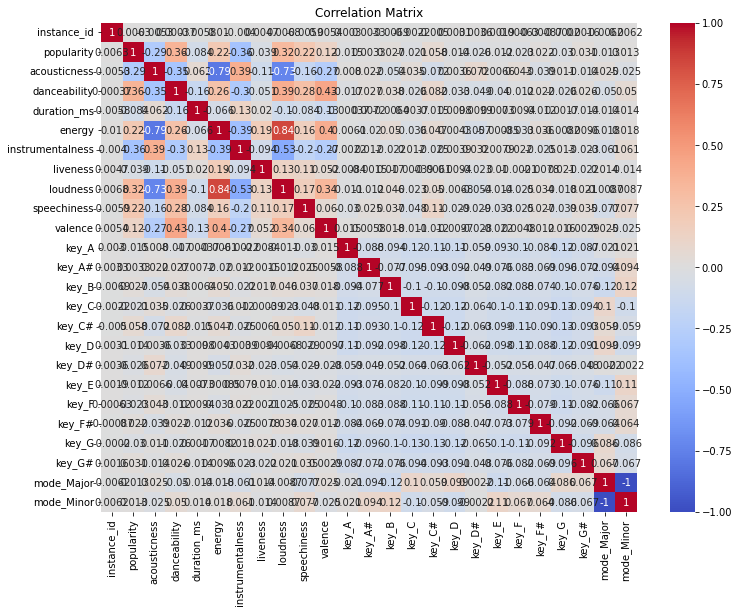

In [ ]:
# Compute the correlation matrix
corr_matrix = data_encoded.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix')


#### Other plots

/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Genres')

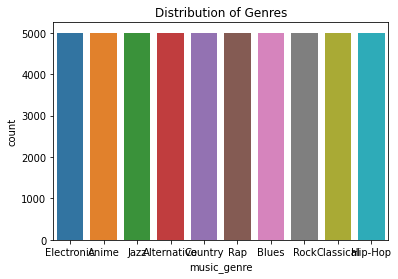

In [ ]:
# Plot the distribution of genres
plt.figure()
sns.countplot(data['music_genre'])
plt.title('Distribution of Genres')


TypeError: Neither the `x` nor `y` variable appears to be numeric.

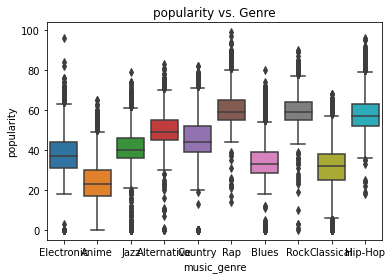

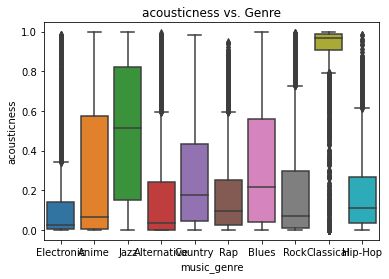

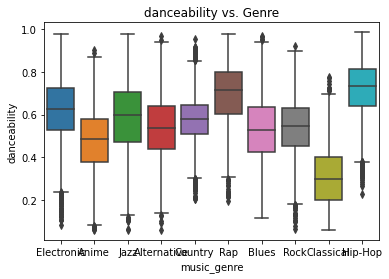

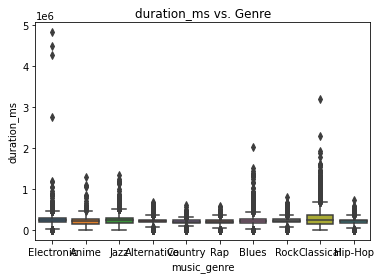

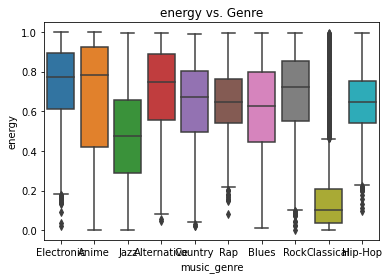

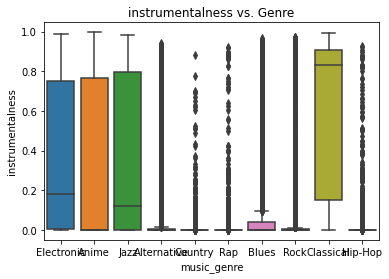

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot boxplots for each feature against the target variable (genre)
for feature in features:
    plt.figure()
    sns.boxplot(x='music_genre', y=feature, data=data)
    print()
    plt.title(f'{feature} vs. Genre')


## Data Preping and Experimenting with Dimensionality Reduction

In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49999 entries, 0 to 50004
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        49999 non-null  float64
 1   acousticness      49999 non-null  float64
 2   danceability      49999 non-null  float64
 3   duration_ms       49999 non-null  float64
 4   energy            49999 non-null  float64
 5   instrumentalness  49999 non-null  float64
 6   key               49999 non-null  object 
 7   liveness          49999 non-null  float64
 8   loudness          49999 non-null  float64
 9   mode              49999 non-null  object 
 10  speechiness       49999 non-null  float64
 11  tempo             45019 non-null  float64
 12  valence           49999 non-null  float64
 13  music_genre       49999 non-null  object 
dtypes: float64(11), object(3)
memory usage: 5.7+ MB


In [132]:
data['tempo'] = data['tempo'].astype(float)
data['tempo'] = pd.to_numeric(data['tempo'], errors='coerce')
data['tempo'].isna().sum()



4980

In [133]:
nan_counts = data.groupby('music_genre')['tempo'].apply(lambda x: x.isna().sum())

# print the result
print(nan_counts)

music_genre
Alternative    505
Anime          503
Blues          530
Classical      500
Country        514
Electronic     534
Hip-Hop        480
Jazz           479
Rap            496
Rock           439
Name: tempo, dtype: int64


In [134]:
# Drop rows with missing values in the 'music_genre' column
data = data.dropna(subset=['music_genre'])

# Calculate the median tempo for each genre
median_tempo_by_genre = data.groupby('music_genre')['tempo'].median()

# Define a function to fill missing values based on the genre
def fill_tempo_by_genre(row):
    if pd.isnull(row['tempo']):
        return median_tempo_by_genre[row['music_genre']]
    else:
        return row['tempo']

# Apply the function to fill missing values in the 'tempo' column
data['tempo'] = data.apply(fill_tempo_by_genre, axis=1)


In [26]:
from sklearn.preprocessing import StandardScaler

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming your data is in a DataFrame called data, and the target variable is in the 'music_genre' column
target_data = data['music_genre']

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder on your target data and transform it
encoded_target = label_encoder.fit_transform(target_data)

# Extract features and target
X = data.drop(columns=['music_genre'])
y =encoded_target

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
# import umap
from sklearn.metrics import silhouette_score

# Dimensionality reduction methods
methods = {
    'PCA': PCA(n_components=3),
    't-SNE': TSNE(n_components=3, perplexity=30, n_iter=3000, random_state=42)
    }

# Apply dimensionality reduction and compute silhouette scores
reduced_data = {}
silhouette_scores = {}

for method_name, method in methods.items():
    reduced_X = method.fit_transform(X_scaled)
    reduced_data[method_name] = reduced_X
    silhouette_scores[method_name] = silhouette_score(reduced_X, y)
    print(method_name,'Done')


PCA Done
t-SNE Done


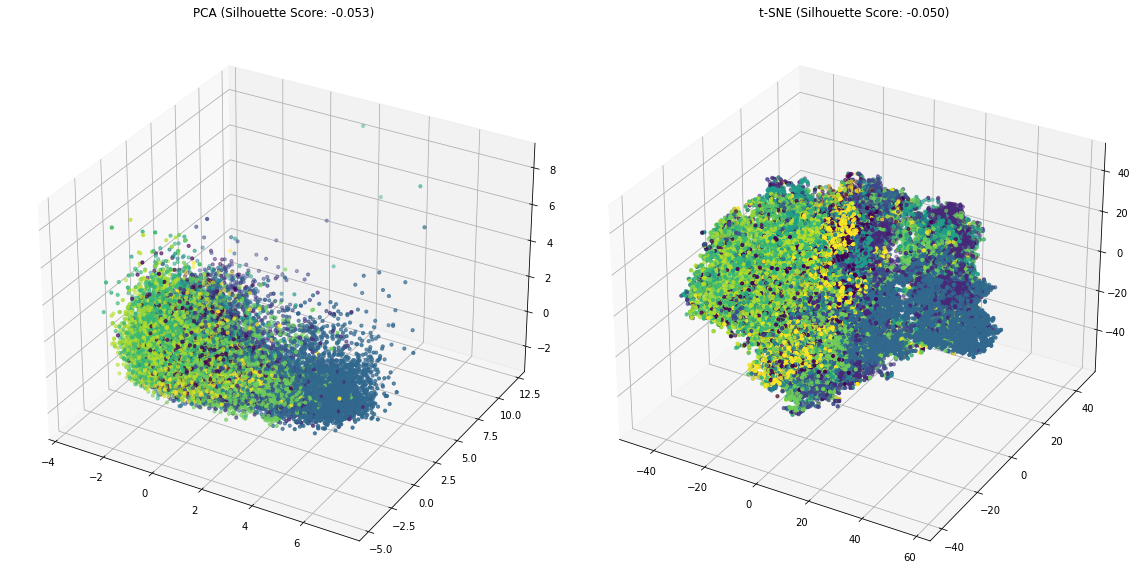

In [30]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 8))

for idx, (method_name, reduced_X) in enumerate(reduced_data.items()):
    ax = fig.add_subplot(1, 2, idx+1, projection='3d')  # creates a 3D subplot
    scatter = ax.scatter(reduced_X[:, 0], reduced_X[:, 1], reduced_X[:, 2], c=y, cmap='viridis', s=10)
    ax.set_title(f'{method_name} (Silhouette Score: {silhouette_scores[method_name]:.3f})')

plt.tight_layout()
plt.show()



### testing PCA + Tsne

-- OBS, Maybe I should try the pca 4 componets, tsne 3 component
- also, add back the keys and mode into the dataset. 

In [84]:
# First, apply PCA
pca = PCA(n_components=3) # Change this to fit your data
X_pca = pca.fit_transform(X_scaled)

# Then apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Then you can plot the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.show()


KeyboardInterrupt: 

fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
Random Forest done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 1 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 2 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 3 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 4 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 5 done
XGBoost done


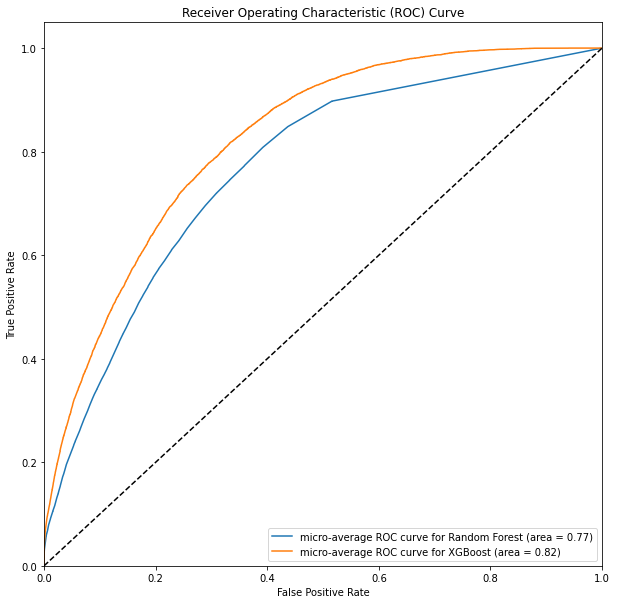

In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ... the rest of your code ...

# Set up the figure for plotting
plt.figure(figsize=(10, 10))

for classifier_name, classifier in classifiers.items():
    accuracy_scores = []
    auc_roc_scores = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    i = 1
    for train_index, test_index in kf.split(X_tsne, y):
        X_train, X_test = X_tsne[train_index], X_tsne[test_index]
        y_train, y_test = y_binarized[train_index], y_binarized[test_index]
        
        classifier.fit(X_train, y_train)
        y_score = classifier.predict_proba(X_test)
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(y_test.shape[1]):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
        
            tprs.append(np.interp(mean_fpr, fpr[j], tpr[j]))
            
        print('fold',i,'done')
        i+=1
        
    print(classifier_name, 'done')
    
    # Calculate mean tpr
    mean_tpr = np.mean(tprs, axis=0)
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
        # Plot ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve for {0} (area = {1:0.2f})'
                   ''.format(classifier_name, roc_auc["micro"]))

# Plot base line
plt.plot([0, 1], [0, 1], 'k--')

# Set plot labels and legends
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()



## Model Experimenting 

In [32]:
!pip install xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelBinarizer

# Define X (standardized features) and y (target music genres)
X = reduced_X
# y = data[]

# Binarize the labels for AUC-ROC calculation
# label_binarizer = LabelBinarizer()
# y_binarized = label_binarizer.fit_transform(y)

# Set up the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machines': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a custom AUC-ROC scorer for multi-class classification
def multi_class_roc_auc_score(y_true, y_pred_proba, average="macro"):
    return roc_auc_score(y_true, y_pred_proba, average=average, multi_class="ovo")

auc_roc_scorer = make_scorer(multi_class_roc_auc_score, needs_proba=True)

# Perform the experiments and calculate accuracy and AUC-ROC
results = {}
for classifier_name, classifier in classifiers.items():
    accuracy_scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')
    auc_roc_scores = cross_val_score(classifier, X, y, cv=kf, scoring=auc_roc_scorer)
    
    results[classifier_name] = {
        'Accuracy': accuracy_scores.mean(),
        'AUC-ROC': auc_roc_scores.mean()
    }

# Display the results
results_df = pd.DataFrame(results).transpose()
print(results_df)


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in

                         Accuracy   AUC-ROC
Logistic Regression      0.305566  0.790516
Random Forest            0.456469  0.863476
Support Vector Machines  0.433749  0.851400
K-Nearest Neighbors      0.475609  0.827669
XGBoost                  0.471309  0.873206


## Using only Random forest and Xboost, also using OneVsRestClassifier with KFold and non-reduced dataset. 

In [80]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, make_scorer,accuracy_score

# ... assuming X, y are defined ...

# Binarize the labels for AUC-ROC calculation
label_binarizer = LabelBinarizer()
y_binarized = label_binarizer.fit_transform(y)

print(y_binarized)
# Set up the classifiers
classifiers = {
    'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=42)),
    'XGBoost': OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
}

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a custom AUC-ROC scorer for multi-class classification
def multi_class_roc_auc_score(y_true, y_score, average="macro"):
    return roc_auc_score(y_true, y_score, average=average, multi_class="ovo")

auc_roc_scorer = make_scorer(multi_class_roc_auc_score, needs_proba=True)

# Perform the experiments and calculate accuracy and AUC-ROC
results = {}
for classifier_name, classifier in classifiers.items():
    accuracy_scores = []
    auc_roc_scores = []
    i = 1
    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_binarized[train_index], y_binarized[test_index]
        
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_score = classifier.predict_proba(X_test)
        
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        auc_roc_scores.append(multi_class_roc_auc_score(y_test, y_score))
        results[classifier_name]= {"Accuracy":np.mean(accuracy_scores),
                                "AUC" : np.mean(auc_roc_scores)}
        print('fold',i,'done')
        i+=1
    print(classifier_name, 'done')
    # Display the results
results_df = pd.DataFrame(results).transpose()
print(results_df)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
Random Forest done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 1 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 2 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 3 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 4 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 5 done
XGBoost done
               Accuracy       AUC
Random Forest  0.381768  0.918684
XGBoost        0.457969  0.936215


fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
Random Forest done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 1 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 2 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 3 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 4 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 5 done
XGBoost done


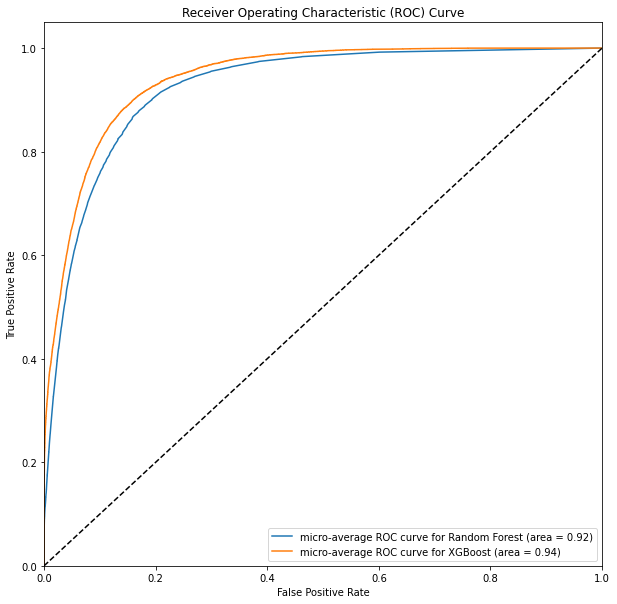

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ... the rest of your code ...

# Set up the figure for plotting
plt.figure(figsize=(10, 10))

for classifier_name, classifier in classifiers.items():
    accuracy_scores = []
    auc_roc_scores = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    i = 1
    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_binarized[train_index], y_binarized[test_index]
        
        classifier.fit(X_train, y_train)
        y_score = classifier.predict_proba(X_test)
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(y_test.shape[1]):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
        
            tprs.append(np.interp(mean_fpr, fpr[j], tpr[j]))
            
        print('fold',i,'done')
        i+=1
        
    print(classifier_name, 'done')
    
    # Calculate mean tpr
    mean_tpr = np.mean(tprs, axis=0)
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
        # Plot ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve for {0} (area = {1:0.2f})'
                   ''.format(classifier_name, roc_auc["micro"]))

# Plot base line
plt.plot([0, 1], [0, 1], 'k--')

# Set plot labels and legends
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()



### Testing LDA data reduced

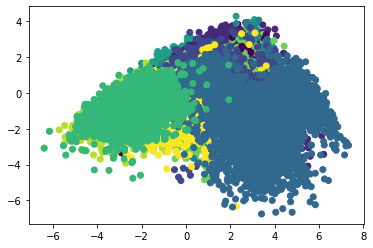

<Figure size 432x288 with 0 Axes>

In [73]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
reduced_X_lda = lda.fit_transform(X_scaled, y)

# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(1, 2, idx+1, projection='3d')  # creates a 3D subplot
# scatter = ax.scatter(reduced_X_lda[:, 0], reduced_X_lda[:, 1], c=y, cmap='viridis', s=10)
# ax.set_title(f'{method_name} (Silhouette Score: {silhouette_scores[method_name]:.3f})')
import matplotlib.pyplot as plt

plt.scatter(reduced_X_lda[:, 0], reduced_X_lda[:, 1], c=y)
plt.show()

plt.tight_layout()
plt.show()

In [69]:
label_binarizer = LabelBinarizer()
y_binarized = label_binarizer.fit_transform(y)

print(y_binarized)
# Set up the classifiers
classifiers = {
    'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=42)),
    'XGBoost': OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
}

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a custom AUC-ROC scorer for multi-class classification
def multi_class_roc_auc_score(y_true, y_score, average="macro"):
    return roc_auc_score(y_true, y_score, average=average, multi_class="ovo")

auc_roc_scorer = make_scorer(multi_class_roc_auc_score, needs_proba=True)

# Perform the experiments and calculate accuracy and AUC-ROC
results = {}
for classifier_name, classifier in classifiers.items():
    accuracy_scores = []
    auc_roc_scores = []
    for train_index, test_index in kf.split(reduced_X_lda, y):
        X_train, X_test = reduced_X_lda[train_index], reduced_X_lda[test_index]
        y_train, y_test = y_binarized[train_index], y_binarized[test_index]
        
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_score = classifier.predict_proba(X_test)
        
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        auc_roc_scores.append(multi_class_roc_auc_score(y_test, y_score))
        results[classifier_name]= {"Accuracy":np.mean(accuracy_scores),
                                   "AUC" : np.mean(auc_roc_scores)}
results_df = pd.DataFrame(results).transpose()

results_df

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in

,Accuracy,AUC
Random Forest,0.297566,0.869252
XGBoost,0.281866,0.890257


[0.8896298070293325,
 0.8904336625343051,
 0.8927442311000393,
 0.8896482836556506,
 0.8888285705129878]

## Testing Neural Networks

In [45]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Function to prepare data
def prepare_data(df, target_column, test_size=0.2):
    # Standardize the features
    scaler = StandardScaler()
    # features = scaler.fit_transform(df.drop(target_column, axis=1))
    target_data = data['music_genre']

    # Create a LabelEncoder instance
    label_encoder = LabelEncoder()

    # Fit the encoder on your target data and transform it
    encoded_target = label_encoder.fit_transform(target_data)
    
    # Convert labels to tensor
    labels = torch.tensor(encoded_target)
    
    # Convert features to tensor
    features = torch.tensor(df, dtype=torch.float32)
    
    # Create a dataset
    dataset = CustomDataset(features, labels)
    
    # Split the dataset into training set and test set
    len_train = int(len(dataset) * (1-test_size))
    len_test = len(dataset) - len_train
    train_set, test_set = random_split(dataset, [len_train, len_test])
    
    return train_set, test_set


### Models


In [56]:
# Define the neural network model
class Model1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model1, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

class Model2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model2, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

class Model3(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model3, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.batchnorm = nn.BatchNorm1d(128)  # BatchNorm layer
    
    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = self.batchnorm(x)  # Apply BatchNorm
        x = nn.functional.relu(self.layer2(x))
        x = self.dropout(x)  # Apply Dropout
        x = self.layer3(x)
        return x

### Training

In [37]:
def train_model(model, train_set, test_set, num_epochs=50):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # Create data loaders
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
    
    # Training loop
    for epoch in range(num_epochs):
        for i, (features, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        for features, labels in test_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

    print(f'Accuracy of the network on the test set: {accuracy} %')



### Running

In [57]:
# Prepare data
# without dimensionality reduction
target_column = 'music_genre'


train_set, test_set = prepare_data(X_scaled, target_column)

# Define the number of input features and classes

input_size = len(data.columns) - 1  # minus the target column

num_classes = data[target_column].nunique()

# Initialize and train the first model
model1 = Model1(input_size, num_classes)
print('Training Model 1:')
train_model(model1, train_set, test_set)

# Initialize and train the second model
model2 = Model2(input_size, num_classes)
print('\nTraining Model 2:')
train_model(model2, train_set, test_set)

# Initialize and train the second model
model3 = Model3(input_size, num_classes)
print('\nTraining Model 3:')
train_model(model3, train_set, test_set)



Training Model 3:
Accuracy of the network on the test set: 56.81 %


In [58]:
# Prepare data
# with reduced dataset
target_column = 'music_genre'
train_set, test_set = prepare_data(reduced_X, target_column)

# Define the number of input features and classes
input_size = 3  # minus the target column
num_classes = data[target_column].nunique()

# Initialize and train the first model
model1 = Model1(input_size, num_classes)
print('Training Model 1:')
train_model(model1, train_set, test_set)

# Initialize and train the second model
model2 = Model2(input_size, num_classes)
print('\nTraining Model 2:')
train_model(model2, train_set, test_set)

# Initialize and train the second model
model3 = Model3(input_size, num_classes)
print('\nTraining Model 3:')
train_model(model3, train_set, test_set)

Training Model 1:
Accuracy of the network on the test set: 46.36 %

Training Model 2:
Accuracy of the network on the test set: 46.41 %

Training Model 3:
Accuracy of the network on the test set: 43.05 %


### trying OVR on the NN 

In [74]:
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import TensorDataset, DataLoader
import torch

class SklearnCompatibleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=10, lr=0.01):
        self.model = model
        self.epochs = epochs
        self.lr = lr

    def fit(self, X, y):
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.long))
        dataloader = DataLoader(dataset, batch_size=32)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = torch.nn.CrossEntropyLoss()
        
        self.model.train()
        for _ in range(self.epochs):
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        return self

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float))
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
        return probabilities.numpy()

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

from sklearn.multiclass import OneVsRestClassifier

# Define the number of input features and classes

input_size = len(data.columns) - 1  # minus the target column

num_classes = data[target_column].nunique()

# Initialize and train the second model
model2 = Model2(input_size, num_classes)
print('\nTraining Model 2:')




Training Model 2:


In [221]:
accuracy_scores = []
auc_roc_scores = []
i =1
for train_index, test_index in kf.split(data_encoded_km, y):
    X_train, X_test = data_encoded_km.iloc[train_index], data_encoded_km.iloc[test_index]
    y_train, y_test = y_binarized[train_index], y_binarized[test_index]
    
        # Assuming `nn_model` is your PyTorch model
    sklearn_compatible_nn = SklearnCompatibleNN(model2)

    ovr_classifier = OneVsRestClassifier(sklearn_compatible_nn)
    ovr_classifier.fit(X_train, y_train)
    
    y_pred = ovr_classifier.predict(X_test)
    y_score = ovr_classifier.predict_proba(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    auc_roc_scores.append(multi_class_roc_auc_score(y_test, y_score))
    results[classifier_name]= {"Accuracy":np.mean(accuracy_scores),
                                "AUC" : np.mean(auc_roc_scores)}
    i +=1
    print("processed",i)

ValueError: could not determine the shape of object type 'DataFrame'

In [77]:
results_df = pd.DataFrame(results).transpose()

results_df

,Accuracy,AUC
Random Forest,0.297566,0.869252
XGBoost,0.165504,0.720241


## testing the best performing archtectures with keys and mode in the dataset 

In [192]:
# data_encoded_km['tempo'] = data_encoded_km['tempo'].astype(float)
data_encoded_km['tempo'] = pd.to_numeric(data_encoded_km['tempo'], errors='coerce')
data_encoded_km['tempo'].isna().sum()

4980

In [193]:
# Calculate the median of the "duration_ms" column, excluding -1 values
median_duration = data_encoded_km.loc[data_encoded_km['duration_ms'] > -1, 'duration_ms'].median()

# Replace -1 values in "duration_ms" column with the calculated median
data_encoded_km['duration_ms'] = data_encoded_km['duration_ms'].replace(-1, median_duration)


In [194]:
data_encoded_km.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
count,49999.000000,49999.000000,49999.000000,4.999900e+04,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,45019.000000,...,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000
mean,44.220844,0.306383,0.558238,2.437080e+05,0.599759,0.181587,0.193898,-9.133669,0.093588,119.953677,...,0.075782,0.110422,0.108102,0.105302,0.031801,0.075202,0.086822,0.062021,0.114542,0.066381
std,15.541874,0.341343,0.178633,1.059233e+05,0.264560,0.325397,0.161638,6.163017,0.101374,30.641664,...,0.264651,0.313418,0.310513,0.306945,0.175471,0.263719,0.281576,0.241197,0.318472,0.248950
min,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,0.020000,0.442000,1.948750e+05,0.433000,0.000000,0.096900,-10.859500,0.036100,94.942000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,0.144000,0.568000,2.273600e+05,0.643000,0.000158,0.126000,-7.276000,0.048900,119.880000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,0.552000,0.687000,2.686060e+05,0.815000,0.155000,0.244000,-5.173000,0.098550,140.474500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [195]:
nan_counts = data.groupby('music_genre')['tempo'].apply(lambda x: x.isna().sum())

# print the result
print(nan_counts)


music_genre
Alternative    0
Anime          0
Blues          0
Classical      0
Country        0
Electronic     0
Hip-Hop        0
Jazz           0
Rap            0
Rock           0
Name: tempo, dtype: int64


In [196]:
# Drop rows with missing values in the 'music_genre' column
data_encoded_km = data_encoded_km.dropna(subset=['music_genre'])

# Calculate the median tempo for each genre
median_tempo_by_genre = data_encoded_km.groupby('music_genre')['tempo'].median()

# Define a function to fill missing values based on the genre
def fill_tempo_by_genre(row):
    if pd.isnull(row['tempo']):
        return median_tempo_by_genre[row['music_genre']]
    else:
        return row['tempo']

# Apply the function to fill missing values in the 'tempo' column
data_encoded_km['tempo'] = data_encoded_km.apply(fill_tempo_by_genre, axis=1)


#### Plotting feature distribution

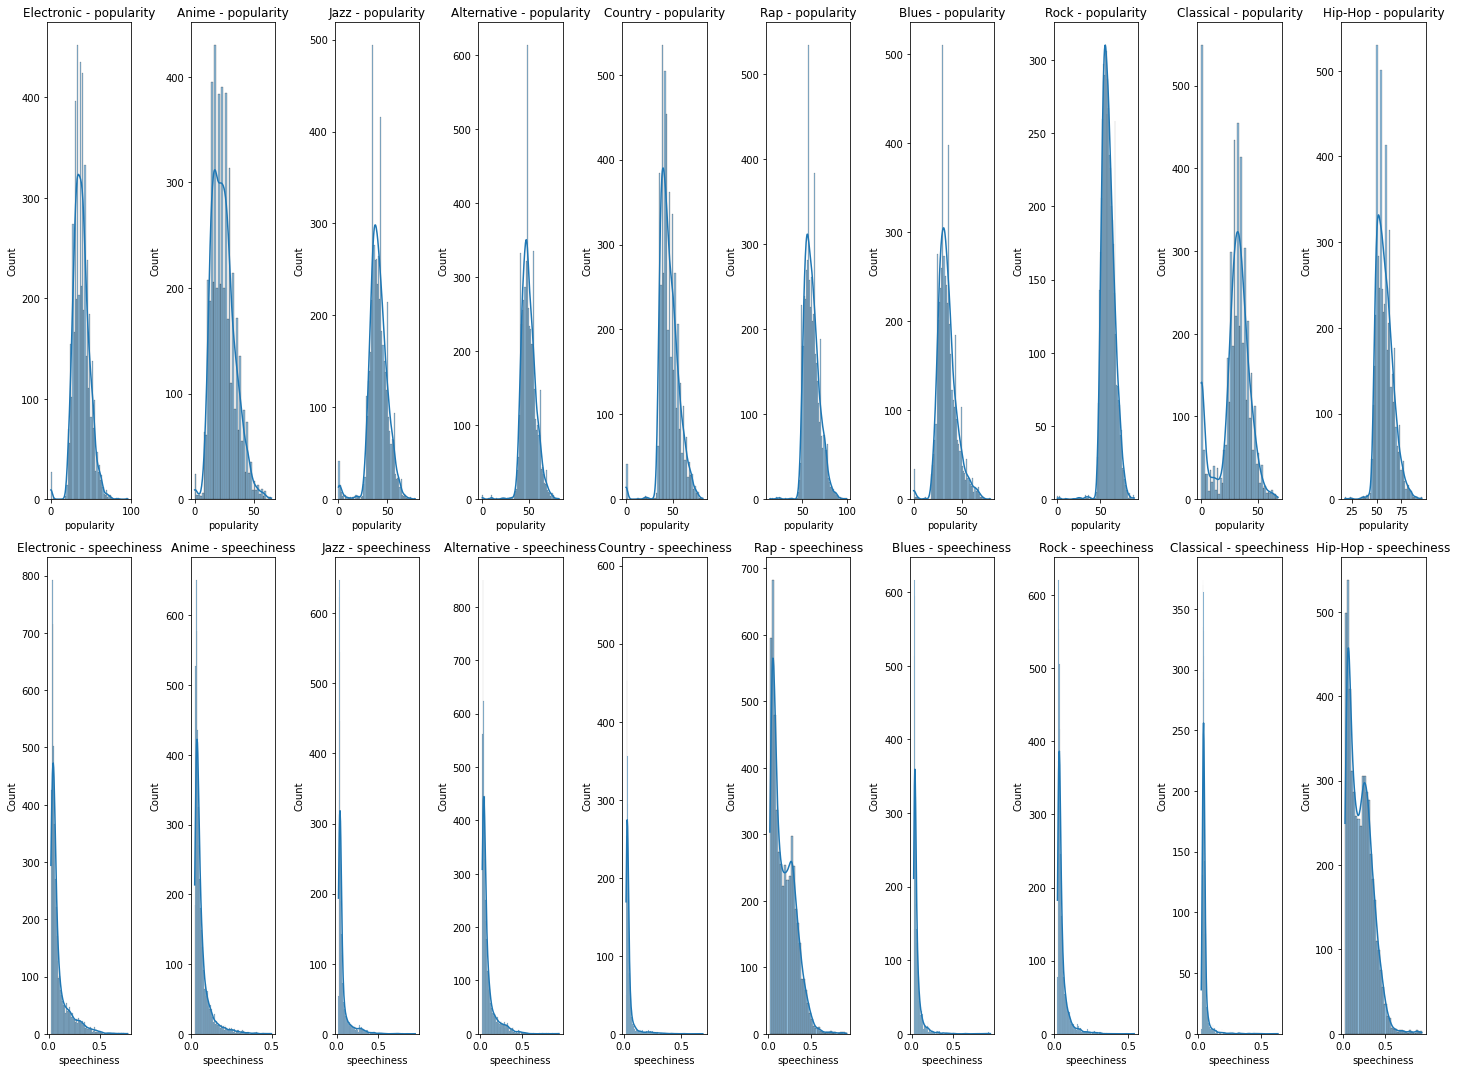

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of features and genres
features = ['popularity', 'speechiness']
genres = data_encoded_km['music_genre'].unique()

# Create a figure with a subplot for each feature per genre
fig, axs = plt.subplots(nrows=len(features), ncols=len(genres), figsize=(20, 15))

# Iterate over each genre
for j, genre in enumerate(genres):
    # Filter dataframe by genre
    df_genre = data_encoded_km[data_encoded_km['music_genre'] == genre]
    
    # Iterate over each feature
    for i, feature in enumerate(features):
        # Create a subplot for each feature per genre
        sns.histplot(data=df_genre, x=feature, kde=True, ax=axs[i][j])
        axs[i][j].set_title(f'{genre} - {feature}')

# Display the plot
plt.tight_layout()
plt.show()


In [142]:
data_encoded_km.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
count,49999.000000,49999.000000,49999.000000,4.999900e+04,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,...,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000
mean,44.220844,0.306383,0.558238,2.212488e+05,0.599759,0.181587,0.193898,-9.133669,0.093588,119.757007,...,0.075782,0.110422,0.108102,0.105302,0.031801,0.075202,0.086822,0.062021,0.114542,0.066381
std,15.541874,0.341343,0.178633,1.286705e+05,0.264560,0.325397,0.161638,6.163017,0.101374,29.226679,...,0.264651,0.313418,0.310513,0.306945,0.175471,0.263719,0.281576,0.241197,0.318472,0.248950
min,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.859500,0.036100,96.551500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,0.144000,0.568000,2.192800e+05,0.643000,0.000158,0.126000,-7.276000,0.048900,120.053000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,0.552000,0.687000,2.686060e+05,0.815000,0.155000,0.244000,-5.173000,0.098550,139.468500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [197]:
from sklearn.preprocessing import StandardScaler

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming your data is in a DataFrame called data, and the target variable is in the 'music_genre' column
target_data = data_encoded_km['music_genre']

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder on your target data and transform it
encoded_target = label_encoder.fit_transform(target_data)

# Extract features and target
X = data_encoded_km.drop(columns=['music_genre'])
y =encoded_target

cols = ['popularity','duration_ms','loudness','tempo']
# Scale the data
scaler = StandardScaler()
X[cols] = scaler.fit_transform(X[cols])

In [150]:
# First, apply PCA
# pca = PCA(n_components=5) # Change this to fit your data
# X_pca = pca.fit_transform(X)

# Then apply t-SNE
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X)


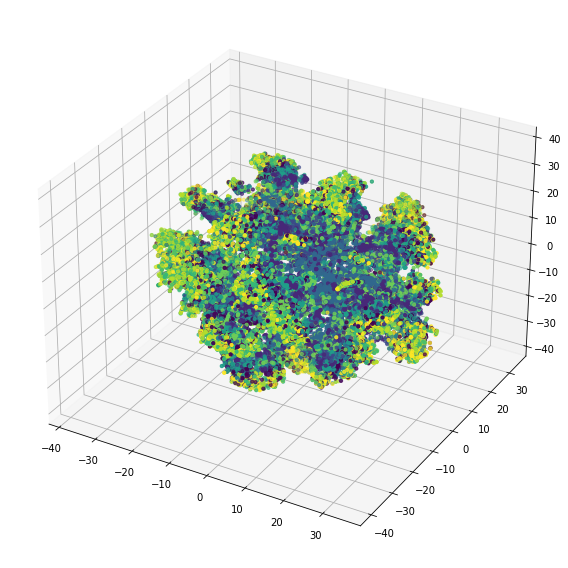

In [151]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1, 2, idx+1, projection='3d')  # creates a 3D subplot
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='viridis', s=10)
plt.tight_layout()
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
Random Forest done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 1 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 2 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 3 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 4 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 5 done
XGBoost done
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
AdaBoost done


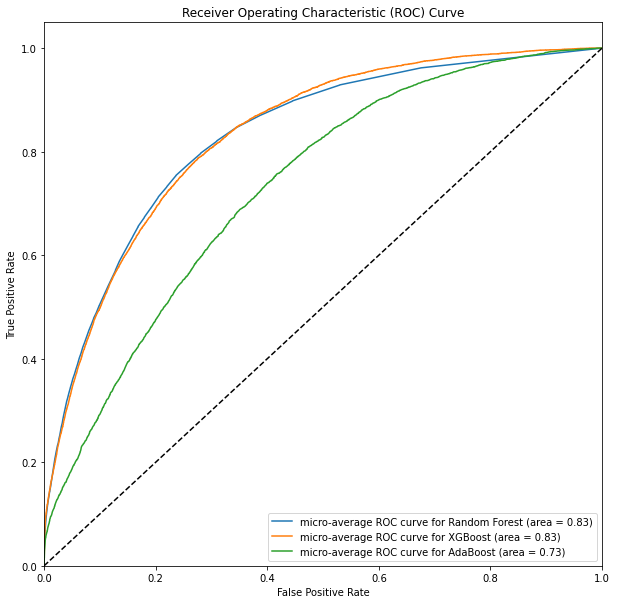

In [152]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier

# ... the rest of your code ...
# Binarize the labels for AUC-ROC calculation
label_binarizer = LabelBinarizer()
y_binarized = label_binarizer.fit_transform(y)

print(y_binarized)
# Set up the classifiers
classifiers = {
    'Random Forest': OneVsRestClassifier(RandomForestClassifier()),
    'XGBoost': OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, learning_rate=0.5))
}

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a custom AUC-ROC scorer for multi-class classification
def multi_class_roc_auc_score(y_true, y_score, average="macro"):
    return roc_auc_score(y_true, y_score, average=average, multi_class="ovo")

auc_roc_scorer = make_scorer(multi_class_roc_auc_score, needs_proba=True)

# Perform the experiments and calculate accuracy and AUC-ROC
results = {}
# Set up the figure for plotting
plt.figure(figsize=(10, 10))

for classifier_name, classifier in classifiers.items():
    accuracy_scores = []
    auc_roc_scores = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    i = 1
    for train_index, test_index in kf.split(X_tsne, y):
        X_train, X_test = X_tsne[train_index], X_tsne[test_index]
        y_train, y_test = y_binarized[train_index], y_binarized[test_index]
        
        classifier.fit(X_train, y_train)
        y_score = classifier.predict_proba(X_test)
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(y_test.shape[1]):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
        
            tprs.append(np.interp(mean_fpr, fpr[j], tpr[j]))
            
        print('fold',i,'done')
        i+=1
        
    print(classifier_name, 'done')
    
    # Calculate mean tpr
    mean_tpr = np.mean(tprs, axis=0)
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
        # Plot ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve for {0} (area = {1:0.2f})'
                   ''.format(classifier_name, roc_auc["micro"]))

# Plot base line
plt.plot([0, 1], [0, 1], 'k--')

# Set plot labels and legends
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
Random Forest done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 1 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 2 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 3 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 4 done


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


fold 5 done
XGBoost done
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
AdaBoost done


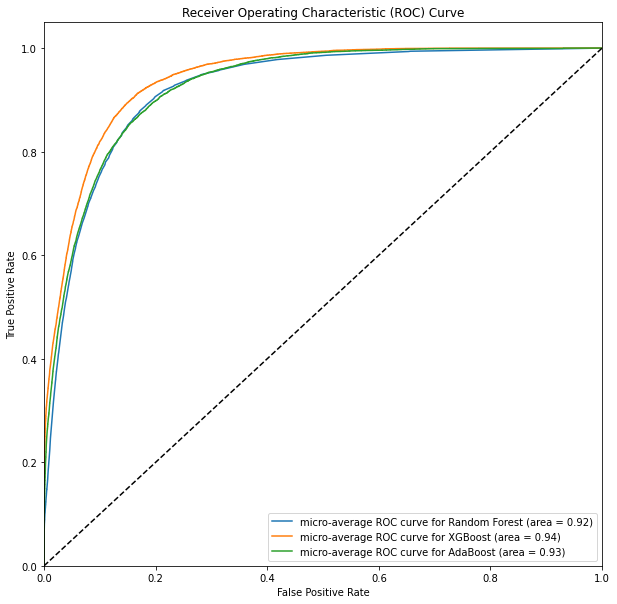

In [154]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
X_array = X.values

# or
X_array = X.to_numpy()
# ... the rest of your code ...
# Binarize the labels for AUC-ROC calculation
label_binarizer = LabelBinarizer()
y_binarized = label_binarizer.fit_transform(y)

print(y_binarized)
# Set up the classifiers
classifiers = {
    'Random Forest': OneVsRestClassifier(RandomForestClassifier()),
    'XGBoost': OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, learning_rate=0.5))
}

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a custom AUC-ROC scorer for multi-class classification
def multi_class_roc_auc_score(y_true, y_score, average="macro"):
    return roc_auc_score(y_true, y_score, average=average, multi_class="ovo")

auc_roc_scorer = make_scorer(multi_class_roc_auc_score, needs_proba=True)

# Perform the experiments and calculate accuracy and AUC-ROC
results = {}
# Set up the figure for plotting
plt.figure(figsize=(10, 10))

for classifier_name, classifier in classifiers.items():
    accuracy_scores = []
    auc_roc_scores = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    i = 1
    for train_index, test_index in kf.split(X_array, y):
        X_train, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_binarized[train_index], y_binarized[test_index]
        
        classifier.fit(X_train, y_train)
        y_score = classifier.predict_proba(X_test)
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(y_test.shape[1]):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
        
            tprs.append(np.interp(mean_fpr, fpr[j], tpr[j]))
            
        print('fold',i,'done')
        i+=1
        
    print(classifier_name, 'done')
    
    # Calculate mean tpr
    mean_tpr = np.mean(tprs, axis=0)
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
        # Plot ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve for {0} (area = {1:0.2f})'
                   ''.format(classifier_name, roc_auc["micro"]))

# Plot base line
plt.plot([0, 1], [0, 1], 'k--')

# Set plot labels and legends
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()


In [164]:
X

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
0,-1.108040,0.00468,0.652,-1.719524,0.941,0.79200,0.115,0.638114,0.0748,-0.645581,...,0,0,0,0,0,0,0,0,0,0
1,-0.850668,0.01270,0.622,-0.022972,0.890,0.95000,0.124,0.339232,0.0300,-0.162696,...,0,0,0,1,0,0,0,0,0,0
2,-1.043697,0.00306,0.620,-0.043801,0.755,0.01180,0.534,0.732874,0.0345,0.281834,...,0,0,0,0,0,0,0,0,0,1
3,-0.657639,0.02540,0.774,-0.422586,0.700,0.00253,0.157,0.752183,0.2390,0.282518,...,0,0,1,0,0,0,0,0,0,0
4,-0.786325,0.00465,0.638,0.008706,0.587,0.90900,0.157,0.465307,0.0413,0.864937,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,0.950934,0.03340,0.913,-1.719524,0.574,0.00000,0.119,0.342639,0.2980,-0.743472,...,0,0,1,0,0,0,0,0,0,0
50001,1.787393,0.15700,0.709,0.237906,0.362,0.00000,0.109,-0.110390,0.0550,0.078217,...,1,0,0,0,0,0,0,0,0,0
50002,0.436191,0.00597,0.693,-0.246880,0.763,0.00000,0.143,0.598847,0.1460,0.387389,...,0,0,0,1,0,0,0,0,0,0
50003,1.336992,0.08310,0.782,0.322720,0.472,0.00000,0.106,0.668132,0.0441,-1.501075,...,0,0,0,0,0,0,0,0,1,0


In [167]:
!pip install scikit-multilearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [176]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

classifiers = {
    'Random Forest': OneVsRestClassifier(RandomForestClassifier()),
    'XGBoost': OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    'AdaBoost': OneVsRestClassifier(AdaBoostClassifier())
}

# Define the parameter grids
param_grid_rf = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
}

param_grid_xgb = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__learning_rate': [0.01, 0.1, 0.3],
    'estimator__max_depth': [3, 6, 10],
    'estimator__subsample': [0.5, 0.7, 1],
    'estimator__colsample_bytree': [0.5, 0.7, 1],
}

param_grid_ab = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__learning_rate': [0.01, 0.1, 0.5, 1],
}

param_grids = {
    'Random Forest': param_grid_rf,
    'XGBoost': param_grid_xgb,
    'AdaBoost': param_grid_ab,
}

best_models = {}
for model, grid in param_grids.items():
    grid_search = GridSearchCV(classifier, grid, scoring=auc_roc_scorer, cv=5)
    skf = StratifiedKFold(n_splits=2, shuffle=True,random_state=42)
    # Fit the GridSearchCV object to the data
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        grid_search.fit(X_train, y_train)

        # Update the classifier to be the best estimator found by the grid search
        classifier = grid_search.best_estimator_
        best_models[model] = classifier
        print( "best hyperparameters for",model,grid_search.best_estimator_)
    print(model,"done")
    4

/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


KeyboardInterrupt: 

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#
0,-1.108040,0.00468,0.652,-1.719524,0.941,0.79200,0.115,0.638114,0.0748,-0.645581,...,0,0,0,0,0,0,0,0,0,0
1,-0.850668,0.01270,0.622,-0.022972,0.890,0.95000,0.124,0.339232,0.0300,-0.162696,...,0,0,0,1,0,0,0,0,0,0
2,-1.043697,0.00306,0.620,-0.043801,0.755,0.01180,0.534,0.732874,0.0345,0.281834,...,0,0,0,0,0,0,0,0,0,1
3,-0.657639,0.02540,0.774,-0.422586,0.700,0.00253,0.157,0.752183,0.2390,0.282518,...,0,0,1,0,0,0,0,0,0,0
4,-0.786325,0.00465,0.638,0.008706,0.587,0.90900,0.157,0.465307,0.0413,0.864937,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,0.950934,0.03340,0.913,-1.719524,0.574,0.00000,0.119,0.342639,0.2980,-0.743472,...,0,0,1,0,0,0,0,0,0,0
50001,1.787393,0.15700,0.709,0.237906,0.362,0.00000,0.109,-0.110390,0.0550,0.078217,...,1,0,0,0,0,0,0,0,0,0
50002,0.436191,0.00597,0.693,-0.246880,0.763,0.00000,0.143,0.598847,0.1460,0.387389,...,0,0,0,1,0,0,0,0,0,0
50003,1.336992,0.08310,0.782,0.322720,0.472,0.00000,0.106,0.668132,0.0441,-1.501075,...,0,0,0,0,0,0,0,0,1,0


In [223]:
!pip install yellowbrick

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 4.6 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [226]:
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ROCAUC

label_binarizer = LabelBinarizer()
y_binarized = label_binarizer.fit_transform(y)
# Set up the classifiers
classifiers = {
    'Random Forest': OneVsRestClassifier(RandomForestClassifier(n_estimators=200,max_depth=22)),
    'XGBoost': OneVsRestClassifier(XGBClassifier(n_estimators=180,use_label_encoder=False,max_depth=25 ,eval_metric='mlogloss',learning_rate=0.25)),
    'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(n_estimators=180, learning_rate=0.25))
}

# Set up k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

# Define a custom AUC-ROC scorer for multi-class classification
def multi_class_roc_auc_score(y_true, y_score, average="macro"):
    return roc_auc_score(y_true, y_score, average=average, multi_class="ovo")

auc_roc_scorer = make_scorer(multi_class_roc_auc_score, needs_proba=True)

# Perform the experiments and calculate accuracy and AUC-ROC
results = {}
best_models ={'Random Forest':{},
              'XGBoost':{},
              'AdaBoost':{}}

# Set up the figure for plotting
plt.figure(figsize=(10, 10))

for classifier_name, classifier in classifiers.items():
    accuracy_scores = []
    auc_roc_scores = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    i = 1

    # Fit the classifier to the data
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_binarized[train_index], y_binarized[test_index]
        classifier.fit(X_train, y_train)

        y_score = classifier.predict_proba(X_test)
        y_pred = classifier.predict(X_test)  # Add this line to make predictions

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(y_test.shape[0]):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

            tprs.append(np.interp(mean_fpr, fpr[j], tpr[j]))

        # Compute and store accuracy for this fold
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        if 'model' not in best_models[classifier_name]:
            best_models[classifier_name]['model'] = classifier
            best_models[classifier_name]['acc'] = accuracy
        elif  best_models[classifier_name]['acc'] < accuracy:
            best_models[classifier_name]['model'] = classifier
            best_models[classifier_name]['acc'] = accuracy 
               
        print('fold', i, 'done with accuracy:', accuracy)
        i += 1

    print(classifier_name, 'done with average accuracy:', np.mean(accuracy_scores))
    
    # Calculate mean tpr
    mean_tpr = np.mean(tprs, axis=0)
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
        # Plot ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve for {0} (area = {1:0.2f})'
                ''.format(classifier_name, roc_auc["micro"]))

# Plot base line
plt.plot([0, 1], [0, 1], 'k--')

# Set plot labels and legends
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()


/Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 720x720 with 0 Axes>

In [214]:
rf_features = best_models['Random Forest']['model'].estimators_[i].feature_importances_
XG_features = best_models['XGBoost']['model'].estimators_[i].feature_importances_
ada_features = best_models['AdaBoost']['model'].estimators_[i].feature_importances_

<ipython-input-211-e2a4ce22167c>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X.columns, rotation=45, ha='right')


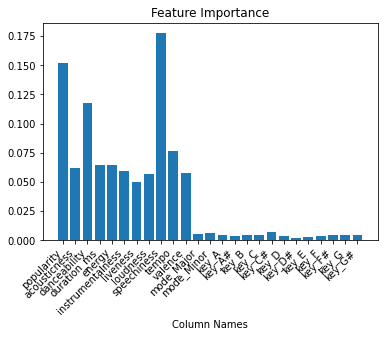

In [211]:
import matplotlib.pyplot as plt

# # Example arrays of column names and feature importance values
# column_names = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4']
# importance_values = [0.8, 0.6, 0.4, 0.2]

# Create a bar graph
fig, ax = plt.subplots()
ax.bar(X.columns, rf_features)
ax.set_xticklabels(X.columns, rotation=45, ha='right')

# Set the x-axis label and title
ax.set_xlabel('Column Names')
ax.set_title('Feature Importance')

# Show the plot
plt.show()

In [219]:
XG_features

array([0.13164312, 0.03053445, 0.05257672, 0.02373594, 0.03612756,
       0.05275662, 0.02475564, 0.02609423, 0.11964536, 0.04674498,
       0.02938886, 0.02610798, 0.        , 0.03124452, 0.02559146,
       0.02190102, 0.03899079, 0.03166347, 0.0269027 , 0.03039969,
       0.04110416, 0.04022598, 0.05176181, 0.0317146 , 0.02838831],
      dtype=float32)

<ipython-input-216-7e3cfde41c14>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X.columns, rotation=90, ha='right')


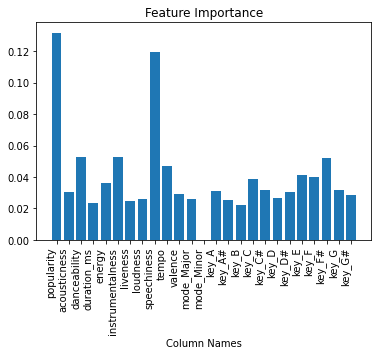

In [216]:
fig, ax = plt.subplots()
ax.bar(X.columns, XG_features)
ax.set_xticklabels(X.columns, rotation=90, ha='right')

# Set the x-axis label and title
ax.set_xlabel('Column Names')
ax.set_title('Feature Importance')

# Show the plot
plt.show()

<ipython-input-215-0a3bb78913e1>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X.columns, rotation=45, ha='right')


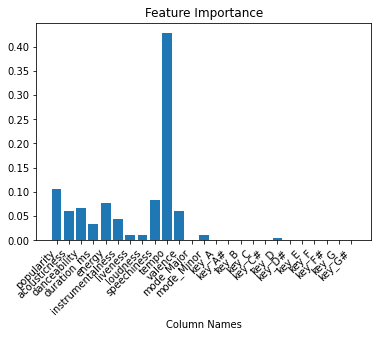

In [215]:
fig, ax = plt.subplots()
ax.bar(X.columns, ada_features)
ax.set_xticklabels(X.columns, rotation=45, ha='right')

# Set the x-axis label and title
ax.set_xlabel('Column Names')
ax.set_title('Feature Importance')

# Show the plot
plt.show()